In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd

from joblib import Parallel, delayed, cpu_count

from copy import deepcopy as copy
from scipy.linalg import eig
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

%matplotlib inline

import sys
import warnings

warnings.filterwarnings("ignore")

### Preliminary investigation of the data - PCA + KMeans Scree Plot using sklearn

In [2]:
data = np.loadtxt("high_variance_distances.dat")
data_pts = data.copy()
print(data.shape)

(7500, 177)


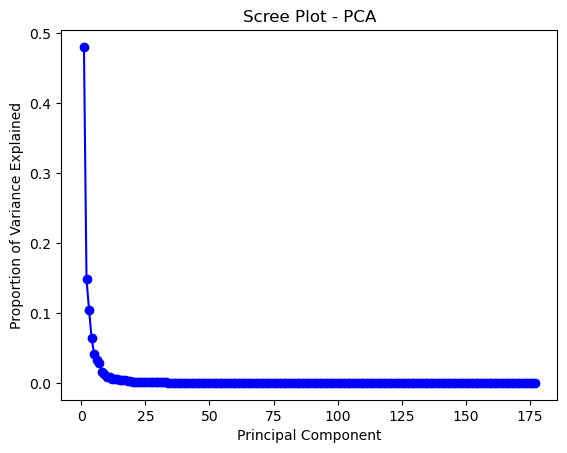

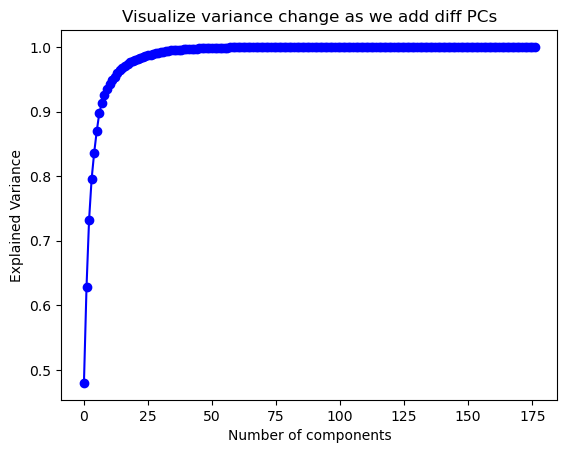

50
150
250
350
450
550
650
750
850
950
CPU times: user 8min 16s, sys: 1min 49s, total: 10min 6s
Wall time: 1min 12s


In [3]:
%%time

pca = PCA()
pca.fit(data)
new_data = pca.transform(data)

PC_values = np.arange(pca.n_components_) + 1

plt.title("Scree Plot - PCA")
plt.plot(PC_values, pca.explained_variance_ratio_, "bo-")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.show()

plt.title("Visualize variance change as we add diff PCs")
plt.ylabel("Explained Variance")
plt.xlabel("Number of components")
plt.plot(np.cumsum(pca.explained_variance_ratio_), "bo-")
plt.show()

# Sklearn Kmeans error estimation to be used for comparing with my own code later
obj_list_skl = []
kmin = 50
kmax = 1050
kstep = 100
for k in range(kmin, kmax, kstep):
    print(k)
    kmeans_skl = KMeans(n_clusters=k).fit(data)
    obj_min = kmeans_skl.inertia_
    obj_list_skl.append(obj_min)

# Find microstates by KMeans/KMeans++/KMedoids

In [4]:
# testing

tmp_data = data.copy()
nc = 11
sel = np.random.choice(np.shape(tmp_data)[0], size=nc, replace=False)
cp = tmp_data[sel]

d2mat = cdist(tmp_data, cp, "sqeuclidean")
min_d2mat = np.array([np.min(d2mat, axis=1)])
tmp_labels = np.argmin(d2mat, axis=1)
tmp_loss = min_d2mat.sum()

new_cp = np.array([tmp_data[tmp_labels == i].mean(axis=0) for i in range(nc)])

print(d2mat.shape)
print(d2mat.mean(axis=0).shape)
print(d2mat.mean(axis=1).shape)
print(cp.shape)
print(new_cp.shape)
print(tmp_labels.shape)
print(min_d2mat.shape)
print(tmp_loss)
print(new_cp.shape)
print(tmp_data[tmp_labels == 1].shape)
print(tmp_data[tmp_labels == 2].shape)
print(tmp_data[tmp_labels == 2].mean(axis=0).shape)


i = rd.randint(0, np.shape(tmp_data)[0] - 1)
tmp_pp_cp = np.array([data[i]])

print(i)
print(tmp_pp_cp.shape)

cki = np.where(tmp_labels == 3)[0]
print(cki.shape)

tmp_D = cdist(data, data, "sqeuclidean")
tmp_c_k_idxs = np.where(tmp_labels == 2)[0]
print(tmp_c_k_idxs.shape)
tmp_intra_cluster_distances = tmp_D[tmp_c_k_idxs, tmp_c_k_idxs[:, np.newaxis]]
tmp_intra_cluster_costs = np.sum(tmp_intra_cluster_distances, axis=1)
print(tmp_intra_cluster_distances.shape)
print(tmp_intra_cluster_costs.shape)

(7500, 11)
(11,)
(7500,)
(11, 177)
(11, 177)
(7500,)
(1, 7500)
6454492.559932549
(11, 177)
(653, 177)
(1090, 177)
(177,)
4036
(1, 177)
(633,)
(1090,)
(1090, 1090)
(1090,)


In [5]:
class kmeans:
    # Initialize the class
    def __init__(self, num_clusters):
        self.num_centroids = num_clusters

    # Function for random initialization
    def init_centroids_random(self):
        # select a random sample of points of size=num_centroids from the total no. of points
        # this random sample acts as initial guesses for cluster centres -> data[select] does that bit
        select_centroids = np.random.choice(self.num_points, size=self.num_centroids, replace=False)
        return self.data[select_centroids]

    # Function for KMeans++ initialization
    def init_centroids_pp(self):
        # choose the first cluster centre at random
        i = rd.randint(0, self.num_points - 1)
        init_centroid = np.array([self.data[i]])

        centroids = init_centroid

        # do till all 'k' cluster centres have been found
        for k in range(1, self.num_centroids):
            D = np.array([])

            # find min distance to already assigned cluster centre/(s) so far
            D = np.append(D, np.min(cdist(self.data, centroids, "sqeuclidean"), axis=1))

            # get the probabilities
            prob = D / np.sum(D)
            cum_prob = np.cumsum(prob)

            # choose a random number to accept or reject new cluster centre (monte-carlo style)
            r = rd.random()
            l = 0
            # we prefer points at larger distances
            for j, p in enumerate(cum_prob):
                if r < p:
                    l = j
                    break

            # new centroid is selected with prob proportional to D
            centroids = np.append(centroids, [self.data[l]], axis=0)

        return centroids

    # Function to "fit" the data to clusters and assign labels to each data point
    def fit(self, data, init="random", max_iterations=1000):
        self.data = data
        self.num_points = np.shape(self.data)[0]

        if init == "k-means++":
            self.centroid_positions = self.init_centroids_pp()
        else:
            self.centroid_positions = self.init_centroids_random()

        # do till maximum iterations reached/convergence achieved
        for count in range(max_iterations):
            # compute distances between each data point and each potential cluster it can be assigned
            dist_sq_matrix = cdist(self.data, self.centroid_positions, "sqeuclidean")

            # choose the minimum distance since that is where the loss is least
            # and that is where it will be assigned
            # so it is used to compute the loss
            min_dist = np.array([np.min(dist_sq_matrix, axis=1)])

            # the cluster to which dist is least is the cluster assigned for a point
            self.labels = np.argmin(dist_sq_matrix, axis=1)

            loss = min_dist.sum()

            # if a cluster has 0 points, reinitialize till it does
            skip = False
            for i in range(self.num_centroids):
                if len(self.data[self.labels == i]) == 0:
                    skip = True
            if skip == True:
                self.centroid_positions = self.init_centroids_random()
                continue

            # mean position of points assigned to a cluster is the new cluster centre (centroid)
            new_centroids = np.array(
                [self.data[self.labels == i].mean(axis=0) for i in range(self.num_centroids)]
            )

            # if all cluster centres remain unchanged, Kmeans has converged
            if np.all(self.centroid_positions == new_centroids):
                break
            self.centroid_positions = new_centroids

        # if max iterations is reached without convergence, then exit and let the user know
        if count == max_iterations - 1:
            print("Maximum iterations reached. Convergence not yet reached.")

        return loss, count, new_centroids, self.labels

    # Plot Clusters
    def plot(self):
        colors = plt.cm.get_cmap("rainbow")(np.linspace(0, 1, self.num_centroids))
        label_set = set(self.labels)
        label_count = len(label_set)
        for centroid in range(self.num_centroids):
            array_points = self.data[self.labels == centroid]
            plt.scatter(array_points[:, 0], array_points[:, 1], color=colors[centroid], s=4)
        plt.scatter(self.centroid_positions[:, 0], self.centroid_positions[:, 1], color="k")
        title_text = "N = %d, k = %d" % (self.num_points, label_count)
        plt.title(title_text)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()

    # Get the labels/assignations for each data point
    def get_assignation(self):
        out = np.empty((self.num_points))
        for i in range(self.num_points):
            out[i] = self.labels[i]
        return out

    # Get the final centroid positions
    def get_centroid_positions(self):
        return self.centroid_positions

In [6]:
class kmedoids:
    # Initialize the class
    def __init__(self, num_medoids):
        self.num_medoids = num_medoids

    # Function for random initialization
    def init_medoids_random(self):
        init_medoid_idxs = np.random.choice(self.num_points, size=self.num_medoids, replace=False)
        return init_medoid_idxs

    # Function to "fit" the data to clusters and assign labels to each data point
    def fit(self, data, max_iterations=1000):
        self.data = data
        self.num_points = np.shape(self.data)[0]

        # get initial guesses for which points are chosen as medoids
        medoid_idxs = self.init_medoids_random()

        # compute distances of each point to each other
        D = cdist(self.data, self.data, "sqeuclidean")

        for count in range(max_iterations):
            old_medoid_idxs = np.copy(medoid_idxs)

            # the minimum distance of a point to a medoid is the cluster assigned to that point
            labels = np.argmin(D[medoid_idxs, :], axis=0)

            # get new medoids
            self.update_medoids(D, labels, medoid_idxs)

            # if they don't change, then KMedoids has converged
            if np.all(old_medoid_idxs == medoid_idxs):
                break

        # new medoid positions are updated
        self.medoid_positions = self.data[medoid_idxs]

        # new labels are updated
        self.labels = np.argmin(D[medoid_idxs, :], axis=0)

        # distance of each point to all medoids is taken to compute loss function values
        dist_sq_matrix = cdist(self.data, self.medoid_positions, "sqeuclidean")
        min_dist = np.array([np.min(dist_sq_matrix, axis=1)])
        loss = min_dist.sum()

        if count == max_iterations - 1:
            print("Maximum iterations reached. Convergence not yet reached.")

        return loss, count, self.medoid_positions, self.labels

    # Function to update medoid positions
    def update_medoids(self, D, labels, medoid_idxs):

        for k in range(self.num_medoids):

            # the indices that are labelled by medoid number 'k'
            cluster_k_indexes = np.where(labels == k)[0]

            # if 0 indices are labelled by a medoid, then skip
            if len(cluster_k_indexes) == 0:
                continue

            # distance between all the points assigned to a given medoid
            intra_cluster_distances = D[cluster_k_indexes, cluster_k_indexes[:, np.newaxis]]

            # minimum cost function for which point
            intra_cluster_all_costs = np.sum(intra_cluster_distances, axis=1)
            min_cost_index = np.argmin(intra_cluster_all_costs)
            min_cost = intra_cluster_all_costs[min_cost_index]

            # current cost is cost at the argmax of the indices belonging to kth medoid
            curr_cost = intra_cluster_all_costs[np.argmax(cluster_k_indexes == medoid_idxs[k])]

            # if cost can be reduced, then update the medoid indices
            if min_cost < curr_cost:
                medoid_idxs[k] = cluster_k_indexes[min_cost_index]

    # Plot the clusters
    def plot(self):
        colors = plt.cm.get_cmap("rainbow")(np.linspace(0, 1, self.num_medoids))
        label_set = set(self.labels)
        label_count = len(label_set)
        for medoid in range(self.num_medoids):
            array_points = self.data[self.labels == medoid]
            plt.scatter(array_points[:, 0], array_points[:, 1], color=colors[medoid], s=4)
        plt.scatter(self.medoid_positions[:, 0], self.medoid_positions[:, 1], color="k")
        title_text = "N = %d, k = %d" % (self.num_points, label_count)
        plt.title(title_text)
        plt.xlabel("x")
        plt.ylabel("y")

    # Get the labels/assignations for each data point
    def get_assignation(self):
        out = np.empty((self.num_points))
        for i in range(self.num_points):
            out[i] = self.labels[i]
        return out

    # Get the final medoid positions
    def get_medoid_positions(self):
        return self.medoid_positions

In [7]:
def plot_clusters(data, centroids, labels):
    colors = plt.cm.get_cmap("rainbow")(np.linspace(0, 1, centroids.shape[0]))

    for i in range(centroids.shape[0]):
        cluster = data[labels == i]
        plt.scatter(cluster[:, 0], cluster[:, 1], color=colors[i], s=4)

    title_text = "N = %d, k = %d" % (centroids.shape[0], labels.shape[0])
    plt.title(title_text)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(centroids[:, 0], centroids[:, 1], c="k")
    plt.show()

## Test for KMeans (random initialization)

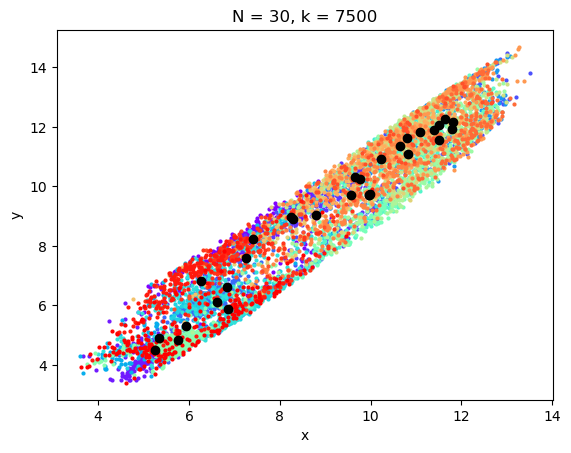

Average Loss =  2669233.565887218
Minimum Loss =  2653133.835149851
Simulation Run corresponding to least loss =  5
Average number of iterations to converge =  42.6
CPU times: user 245 ms, sys: 122 ms, total: 367 ms
Wall time: 3.18 s


In [8]:
%%time

num_simulations = 10
test_km = kmeans(30)
min_loss = np.inf
losses = np.empty(num_simulations)
iterations = np.empty(num_simulations)

results = Parallel(n_jobs=-1)(delayed(test_km.fit)(data, init="random") for i in range(num_simulations))

losses = np.array([results[i][0] for i in range(num_simulations)])
iterations = np.array([results[i][1] for i in range(num_simulations)])
best_results = results[np.argmin(losses)]

min_loss = results[np.argmin(losses)][0]
best_centroid_assignations = results[np.argmin(losses)][2]
best_labels = results[np.argmin(losses)][3]

plot_clusters(data, best_centroid_assignations, best_labels)

print("Average Loss = ", losses.mean())
print("Minimum Loss = ", min_loss)
print("Simulation Run corresponding to least loss = ", np.argmin(losses))
print("Average number of iterations to converge = ", iterations.mean())

## Test for KMeans (K-Means++ initialization)

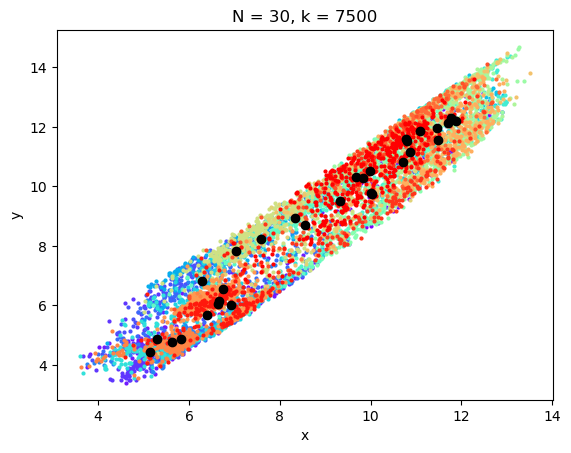

Average Loss =  2669638.4035046618
Minimum Loss =  2638200.8172871172
Simulation Run corresponding to least loss =  0
Average number of iterations to converge =  51.8
CPU times: user 196 ms, sys: 7.19 ms, total: 203 ms
Wall time: 1.99 s


In [9]:
%%time

num_simulations = 10
test_kmpp = kmeans(30)
min_loss = np.inf
losses = np.empty(num_simulations)
iterations = np.empty(num_simulations)

results = Parallel(n_jobs=-1)(delayed(test_kmpp.fit)(data, init="k-means++") for i in range(num_simulations))

losses = np.array([results[i][0] for i in range(num_simulations)])
iterations = np.array([results[i][1] for i in range(num_simulations)])
best_results = results[np.argmin(losses)]

min_loss = results[np.argmin(losses)][0]
best_centroid_assignations = results[np.argmin(losses)][2]
best_labels = results[np.argmin(losses)][3]

plot_clusters(data, best_centroid_assignations, best_labels)

print("Average Loss = ", losses.mean())
print("Minimum Loss = ", min_loss)
print("Simulation Run corresponding to least loss = ", np.argmin(losses))
print("Average number of iterations to converge = ", iterations.mean())

## Test for KMedoids

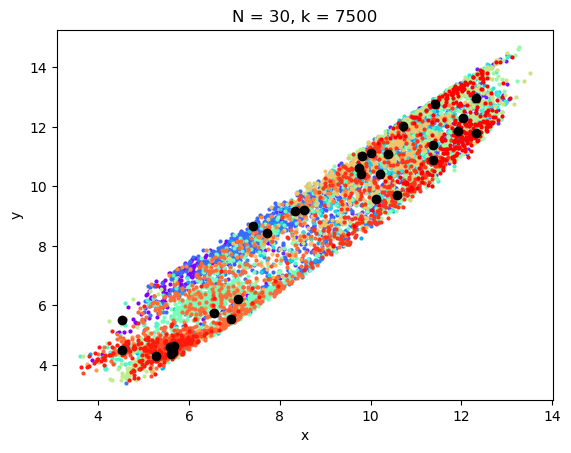

Average Loss =  3797174.6723889634
Minimum Loss =  3624308.4052144485
Simulation Run corresponding to least loss =  8
Average number of iterations to converge =  3.4
CPU times: user 194 ms, sys: 12.8 ms, total: 207 ms
Wall time: 5.82 s


In [10]:
%%time

num_simulations = 10
test_kmed = kmedoids(30)
min_loss = np.inf
losses = np.empty(num_simulations)
iterations = np.empty(num_simulations)

results = Parallel(n_jobs=-1)(delayed(test_kmed.fit)(data) for i in range(num_simulations))

losses = np.array([results[i][0] for i in range(num_simulations)])
iterations = np.array([results[i][1] for i in range(num_simulations)])
best_results = results[np.argmin(losses)]

min_loss = results[np.argmin(losses)][0]
best_centroid_assignations = results[np.argmin(losses)][2]
best_labels = results[np.argmin(losses)][3]

plot_clusters(data, best_centroid_assignations, best_labels)

print("Average Loss = ", losses.mean())
print("Minimum Loss = ", min_loss)
print("Simulation Run corresponding to least loss = ", np.argmin(losses))
print("Average number of iterations to converge = ", iterations.mean())

### Based on these preliminary tests, error is minimum for KMeans++. But random initialization is pretty close and is way faster, so we proceed with that. We ignore KMedoids which has a much higher error.

### Now, let's do a scree plot for KMeans to try and choose an appropriate 'k' for future steps.

In [11]:
%%time

num_simulations = 10
res_k = []

kmin = 50
kmax = 1050
kstep = 100

for k in range(kmin, kmax, kstep):
    print(k)
    km = kmeans(k)

    results = Parallel(n_jobs=-1)(delayed(km.fit)(data, init="random") for i in range(num_simulations))
    losses = np.array([results[i][0] for i in range(num_simulations)])
    min_loss = results[np.argmin(losses)][0]

    print(k, min_loss)
    res_k.append([k, min_loss])

res_k = np.array(res_k)

50
50 2302744.077644326
150
150 1699834.6209673588
250
250 1481927.7031310205
350
350 1353511.0996671245
450
450 1250002.9823623616
550
550 1181085.5350802168
650
650 1130986.9701984148
750
750 1079742.59327377
850
850 1034096.0954673284
950
950 987790.5988863698
CPU times: user 325 ms, sys: 165 ms, total: 490 ms
Wall time: 1min 4s


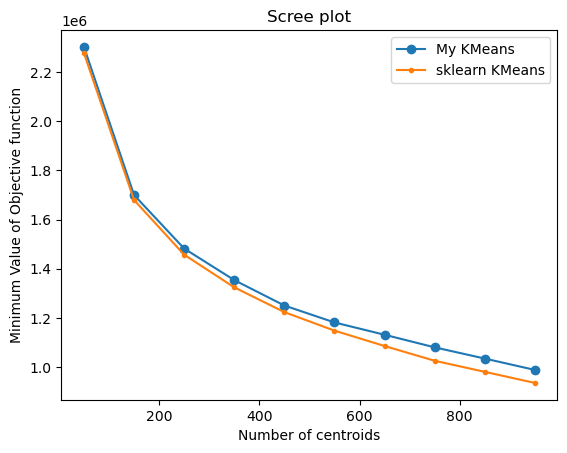

In [12]:
plt.plot(res_k[:, 0], res_k[:, 1], "o-", label="My KMeans")
plt.plot(np.arange(kmin, kmax, kstep), obj_list_skl, ".-", label="sklearn KMeans")
plt.title("Scree plot")
plt.ylabel("Minimum Value of Objective function")
plt.xlabel("Number of centroids")
plt.legend()

# Compute the transition matrix: $\pi_{\alpha, \beta} = P(\beta, \tau | \alpha, 0)$, for a given $\tau$

In [13]:
def transition_matrix(data, labels, k, tau):
    """
    Compute the transition matrix for transitions between every possible pair of microstates.
    --------------------------------
    data: np.ndarray which is 2D
    labels: array with assignations of which cluster ID each data point belongs to.
    k: number of clusters (from KMeans/KMedoids etc)
    tau: time lag
    """

    pi = np.zeros((k, k))
    for i in range(data.shape[0] - tau):
        alpha = labels[i]
        beta = labels[i + tau]
        pi[alpha, beta] += 1

    # print(pi)
    # print(np.sum(pi,axis=1,keepdims=True))

    pi = pi / np.sum(pi, axis=1, keepdims=True)

    # Check properties of a stochastic matrix
    # 1. All elements are positive-defined -> non-negative
    # 2. sum_(alpha) Pi(alpha,beta) = 1 (for all beta)
    #print(np.sum(pi, axis=1))
    assert np.size(np.where(pi < 0)[0]) == 0
    assert np.allclose(np.sum(pi, axis=1), 1.0, atol=1.0e-08)
    # print(pi)

    # eigvals, eigvecs = eig(pi.T) # equivalent to taking left eigenvector
    eigvals, eigvecs = eig(pi, left=True, right=False)

    sorted_index = np.argsort(eigvals)[::-1]
    sorted_eigvals = eigvals[sorted_index]
    sorted_eigvecs = eigvecs[:, sorted_index]

    # stationary distribution is the leeft eigenvector corresponding to eigenvalue=1
    statdist = eigvecs[:, np.isclose(eigvals, 1)].ravel()
    statdist /= np.sum(statdist)

    # compute the relaxation timescales from the eigvals
    # eigvals are complex for the transition matrix, since it is square and non-symmetric
    # np.abs(a) of a complex number (a = 1.7 + 0.3j) gives us the modulus of it
    # np.abs(a) = np.sqrt(np.real(a)**2 + np.imag(a)**2)
    # so the below code is fine, even for complex eigvals
    relaxation_timescales = -tau / np.log(np.abs(eigvals[np.isclose(eigvals, 1) == False]))

    # remember to sort them, since sorting MAY be different from eigval sorting
    relaxation_timescales = relaxation_timescales[np.argsort(relaxation_timescales)[::-1]]

    # print(relaxation_timescales)
    # print(relaxation_timescales.shape)

    return sorted_eigvals, sorted_eigvecs, relaxation_timescales, statdist

# Inspect the sign of the leading eigenvectors to identify the Markov states


1328499.223779215 20


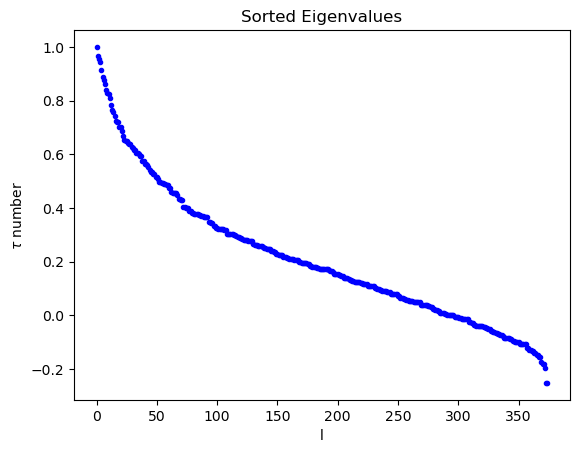

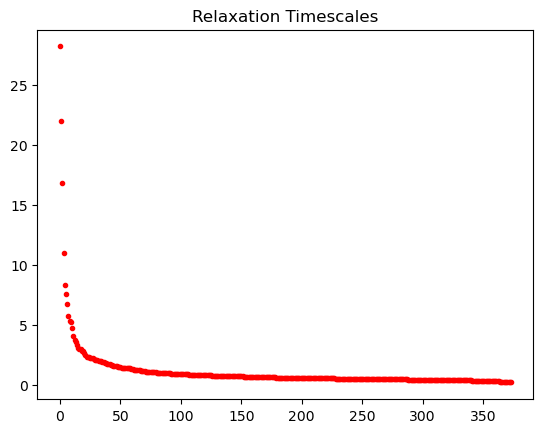

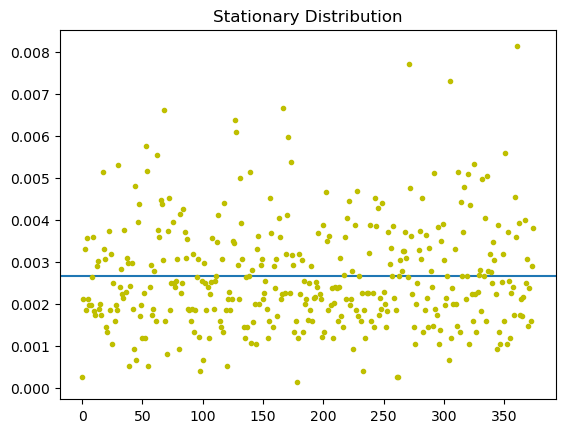

In [14]:
k = 375
km = kmeans(k)
loss, iteration, centroid_positions, _ = km.fit(data=data, init="random")
print(loss, iteration)

labels = km.get_assignation()

tau = 1
eigvals, eigvecs, relaxation_timescales, statdist = transition_matrix(data, labels.astype(np.int64), k, tau)

# Make a plot for eigenvalues
plt.plot(eigvals, "b.")
plt.title("Sorted Eigenvalues")
plt.xlabel(r"l")
plt.ylabel(r"$\tau$ number")
plt.show()

plt.title("Relaxation Timescales")
plt.plot(relaxation_timescales, "r.")
plt.show()

plt.title("Stationary Distribution")
plt.axhline(statdist.mean())
plt.plot(statdist, "y.")
plt.show()

In [15]:
# Number of relevant relaxation timescales chosen from the eigenvalue spectrum of the transition matrix
num_timescales = 2
num_ms = 2**num_timescales  # number of markov states is 2^(number of relevant timescales)

In [16]:
# Array to denote which centroid belongs to which Markov State
ms = np.zeros(k)

# print(ms)

# left eigenvectors of Pi sum to 0 except the first eigenvector
# which corresponds to eigenvalue=1 (equilibrium prob distribution)
assert np.isclose(eigvecs[:, 1::].sum(axis=0), 0.0, atol=1.0e-08).all()

if num_ms == 1:
    for i in range(k):
        if eigvecs[i, 1] > 0:
            # evec[:,1] corresponds to the first eigenvector with a non=1 eigenvalue
            # since log of the eigval is taken, so that eigenvector (evec[:,0], eigval=1) is ignored
            ms[i] = -1
        else:
            ms[i] = +1
elif num_ms == 4:
    for i in range(k):
        if eigvecs[i, 1] > 0 and eigvecs[i, 2] > 0:
            ms[i] = -2
        elif eigvecs[i, 1] > 0 and eigvecs[i, 2] < 0:
            ms[i] = -1
        elif eigvecs[i, 1] < 0 and eigvecs[i, 2] > 0:
            ms[i] = +1
        elif eigvecs[i, 1] < 0 and eigvecs[i, 2] < 0:
            ms[i] = +2
else:
    print("Not explicitly implemented for more than 2 relevant timescales")

In [17]:
# Attempt to automate this markov state discovery pipeline for any general number of chosen relevant timescales
# There may be bugs here

# Number of relevant relaxation timescales chosen from the eigenvalue spectrum of the transition matrix
num_timescales = 2

# number of markov states is 2^(number of relevant timescales)
num_markov_states = 2**num_timescales

markov_states = np.zeros(k)

pos_mask = np.all(eigvecs[:, 1:num_timescales] > 0, axis=1)
neg_mask = np.all(eigvecs[:, 1:num_timescales] < 0, axis=1)

for i in range(1, num_timescales + 1):
    pos_mask_i = (
        pos_mask
        & np.all(eigvecs[:, 1 : i + 1] > 0, axis=1)
        & np.all(eigvecs[:, i + 1 : num_timescales] > 0, axis=1)
    )
    neg_mask_i = (
        neg_mask
        & np.all(eigvecs[:, 1 : i + 1] < 0, axis=1)
        & np.all(eigvecs[:, i + 1 : num_timescales] < 0, axis=1)
    )
    markov_states[pos_mask_i] = -i
    markov_states[neg_mask_i] = i

assert np.isclose((ms - markov_states), 0).all()
# print(markov_states)
# print(ms)
# print(ms-markov_states)

In [18]:
data_ms_assignation = np.zeros_like(labels)

for i in range(len(labels)):
    for j in range(len(markov_states)):
        if labels[i] == j:
            data_ms_assignation[i] = markov_states[j]

print(np.min(data_ms_assignation), np.max(data_ms_assignation))

-2.0 2.0


# Dimensional Reduction of original data and visualization of the Markov States

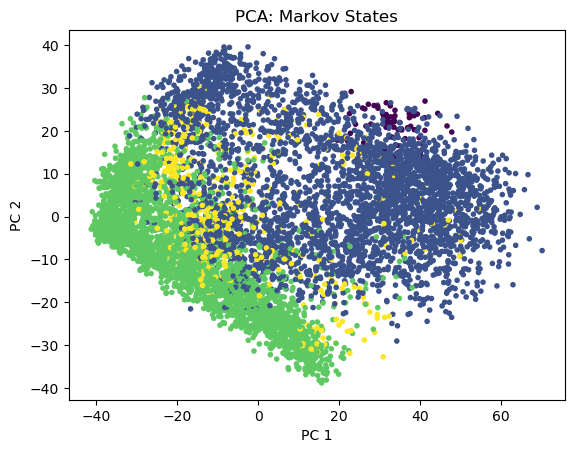

In [19]:
# 4: Dimensionality reduction and visualization
# Perform PCA on the microstates to obtain a 2D embedding

pca_vis = PCA(n_components=2)
data_2d_pca = pca_vis.fit_transform(data)

plt.scatter(data_2d_pca[:, 0], data_2d_pca[:, 1], marker=".", c=data_ms_assignation)
plt.title("PCA: Markov States")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

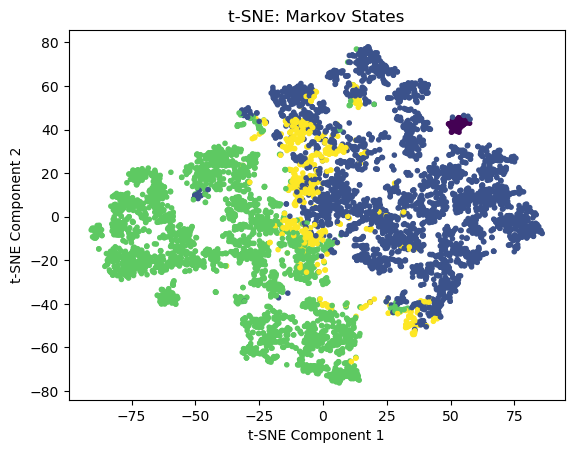

In [20]:
# 4: Dimensionality reduction and visualization
# Perform t-SNE on the microstates to obtain a 2D embedding
# perplexity refers to number of nearest neighbours chosen

data_2d_tsne = TSNE(n_components=2, perplexity=31, random_state=1729).fit_transform(data)

# Plot the Markov states in the embedding
plt.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], marker=".", c=data_ms_assignation)
plt.title("t-SNE: Markov States")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Stability of results w.r.t. $\tau$ and $k$

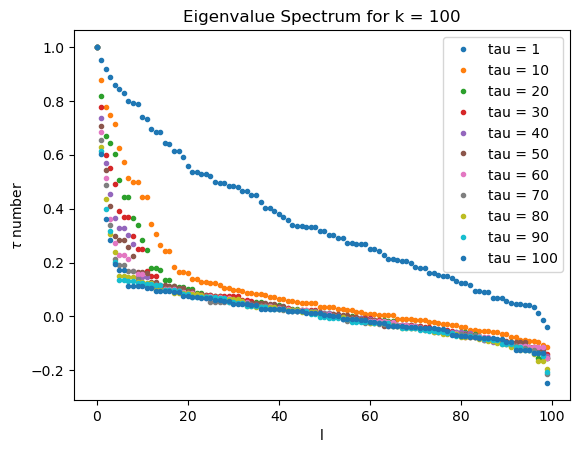

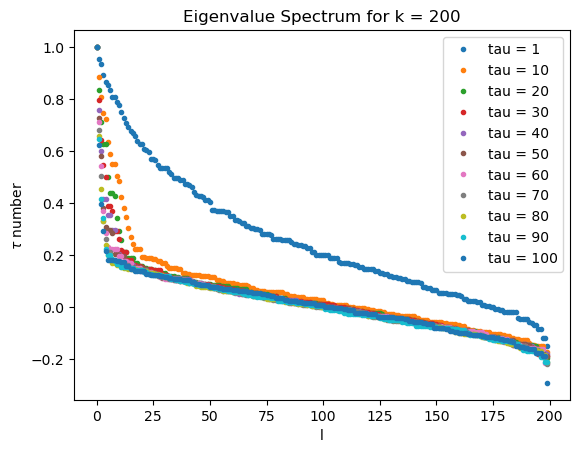

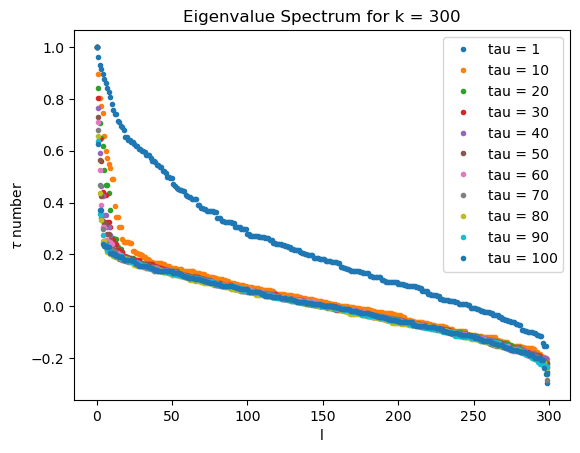

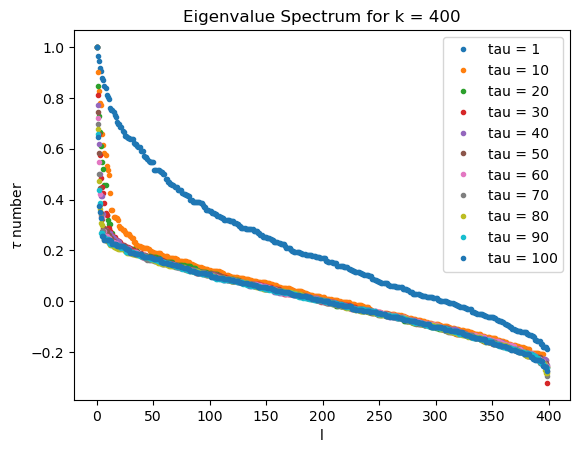

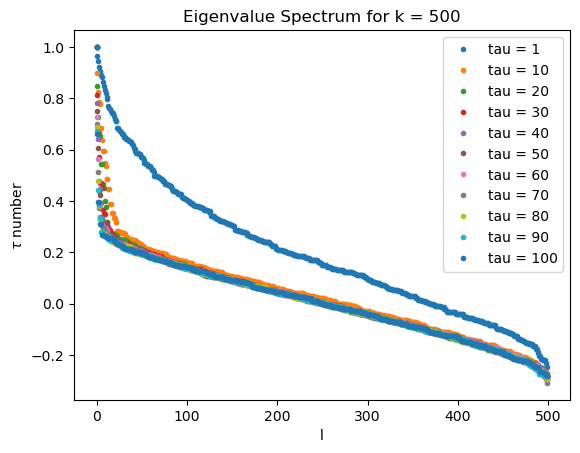

CPU times: user 53.8 s, sys: 14.5 s, total: 1min 8s
Wall time: 21.3 s


In [21]:
%%time

ks = np.ones((5))
ks = np.cumsum(ks) * 100
# 100, ...., 500

taus = np.ones((11))
taus = np.cumsum(taus) * 10 - 10 + 1
taus[1:] = taus[1:] - 1
taus = taus.astype(np.int64)
# 1, 5, 10, ...., 50

for i in range(len(ks)):
    k_local = ks[i].astype(np.int64)
    kmi = kmeans(k_local)
    kmi.fit(data=data, init="random")
    labels_ks = kmi.get_assignation()
    labels_ks = labels_ks.astype(np.int64)

    title_text = "Eigenvalue Spectrum for k = %d" % (k_local)
    plt.title(title_text)
    plt.xlabel(r"l")
    plt.ylabel(r"$\tau$ number")

    # title_text = "Relaxation Timescales for k = %d" % (k_local)
    # plt.title(title_text)

    # results = Parallel(n_jobs=2)(
    #    delayed(transition_matrix)(data, labels_ks, k_local, taus[t]) for t in range(len(taus))
    # )

    # eigvals_ks = np.array([results[i][0] for i in range(len(taus))])

    # for i in range(len(taus)):
    #    plt.plot(eigvals_ks[i, :], ".", label=f"tau = {taus[i]}")

    for t in range(len(taus)):
        eigvals_ks, eigvecs_ks, relaxation_timescales_ks, statdist_ks = transition_matrix(
            data, labels_ks, k_local, taus[t]
        )
        plt.plot(eigvals_ks, ".", label=f"tau = {taus[t]}")
    #    plt.plot(relaxation_timescales_ks, ".", label=f"tau = {taus[t]}")

    plt.legend()
    plt.show()

1325928.9320168323 20


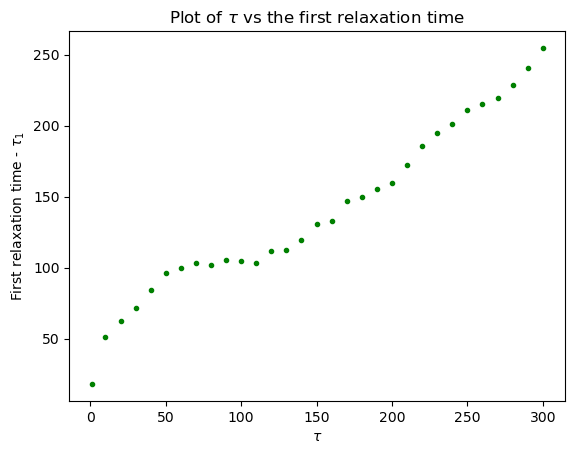

In [22]:
k = 375
km = kmeans(k)
loss, iteration, centroid_positions, _ = km.fit(data=data, init="random")
print(loss, iteration)

labels_ks = km.get_assignation()
labels_ks = labels_ks.astype(np.int64)

taus = np.ones((31))
taus = np.cumsum(taus) * 10 - 10 + 1
taus[1:] = taus[1:] - 1
taus = taus.astype(np.int64)

plt.title(r"Plot of $\tau$ vs the first relaxation time")
plt.xlabel(r"$\tau$")
plt.ylabel(r"First relaxation time - $\tau_1$")

for t in range(len(taus)):
    eigvals_ts, eigvecs_ts, relaxation_timescales_ts, statdist_ts = transition_matrix(
        data, labels_ks, k, taus[t]
    )
    plt.plot(taus[t], relaxation_timescales_ts[1], "g.")

## One observes that the eigenvalue spectrum is similar regardless of the value of $k$ chosen.

## For each $k$, only the behaviour of $\tau = 1$ is significantly different than other values of $\tau$, from $1-100$.

## Also, we observe plotting $\tau_1$ vs $\tau$ that the first relaxation time increases and then plateaus. We want to investigate the Markov States for $\tau$'s in this plateau region since that shows we have a stable $\tau$. Beyond a physically meaningful $\tau$, $\tau_1$ keeps increasing again since $\tau$ becomes longer than the meaningful relaxation time. Then, the longest relaxation time becomes tau itself.

## So, let us also visualize the Markov States for a higher value of $\tau = 100$ (keeping $k = 375$ constant)

1339183.0274228188 29


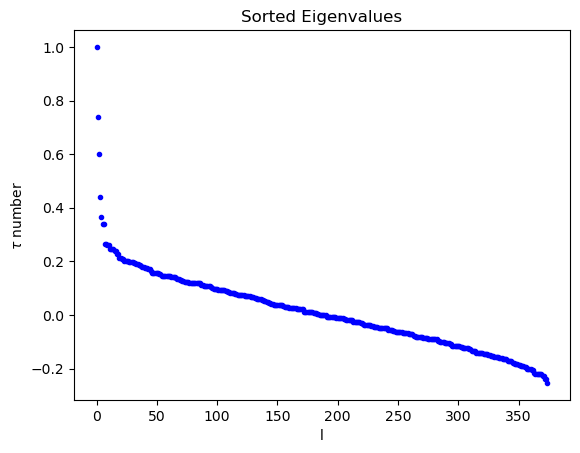

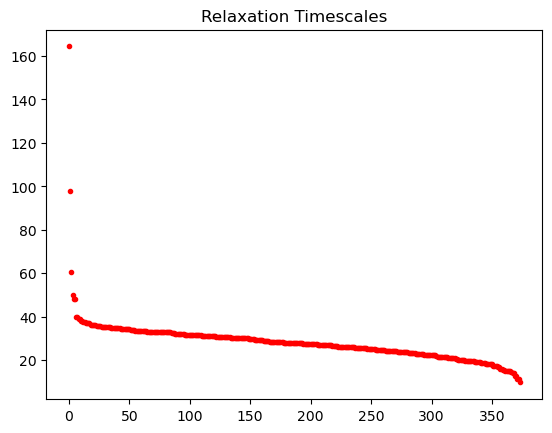

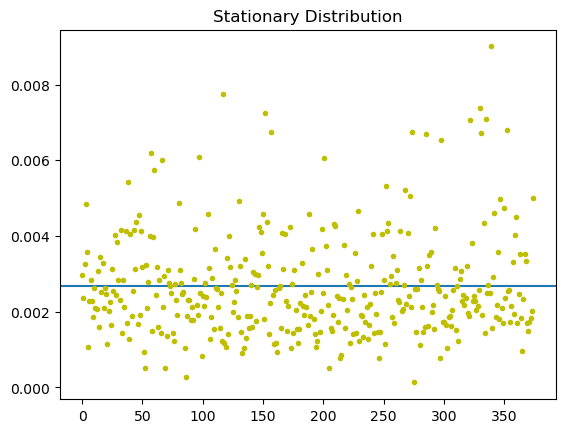

(375, 177)


In [23]:
#m = 1000  # size of the core set
#core_set_indices = np.random.choice(len(data), size=m, replace=False)
#core_set = data[core_set_indices]

k = 375
km = kmeans(k)
loss, iteration, centroid_positions, _ = km.fit(data=data, init="random")
print(loss, iteration)

labels = km.get_assignation()

tau = 50
eigvals, eigvecs, relaxation_timescales, statdist = transition_matrix(data, labels.astype(np.int64), k, tau)
#eigvals, eigvecs, relaxation_timescales, statdist = transition_matrix(core_set, labels.astype(np.int64), k, tau)


# Make a plot for eigenvalues
plt.plot(eigvals, "b.")
plt.title("Sorted Eigenvalues")
plt.xlabel(r"l")
plt.ylabel(r"$\tau$ number")
plt.show()

plt.title("Relaxation Timescales")
plt.plot(relaxation_timescales, "r.")
plt.show()

plt.title("Stationary Distribution")
plt.axhline(statdist.mean())
plt.plot(statdist, "y.")
plt.show()

# centroid_positions = km.get_centroid_positions()
print(centroid_positions.shape)

In [24]:
# Number of relevant relaxation timescales chosen from the eigenvalue spectrum of the transition matrix
num_timescales = 1
num_ms = 2**num_timescales  # number of markov states is 2^(number of relevant timescales)

In [25]:
markov_states = np.zeros(k)

pos_mask = np.all(eigvecs[:, 1:num_timescales] > 0, axis=1)
neg_mask = np.all(eigvecs[:, 1:num_timescales] < 0, axis=1)

for i in range(1, num_timescales + 1):
    pos_mask_i = (
        pos_mask
        & np.all(eigvecs[:, 1 : i + 1] > 0, axis=1)
        & np.all(eigvecs[:, i + 1 : num_timescales] > 0, axis=1)
    )
    neg_mask_i = (
        neg_mask
        & np.all(eigvecs[:, 1 : i + 1] < 0, axis=1)
        & np.all(eigvecs[:, i + 1 : num_timescales] < 0, axis=1)
    )
    markov_states[pos_mask_i] = -i
    markov_states[neg_mask_i] = i

# print(markov_states)

In [26]:
data_ms_assignation = np.zeros_like(labels)

for i in range(len(labels)):
    for j in range(len(markov_states)):
        if labels[i] == j:
            data_ms_assignation[i] = markov_states[j]

print(np.min(data_ms_assignation), np.max(data_ms_assignation))

-1.0 1.0


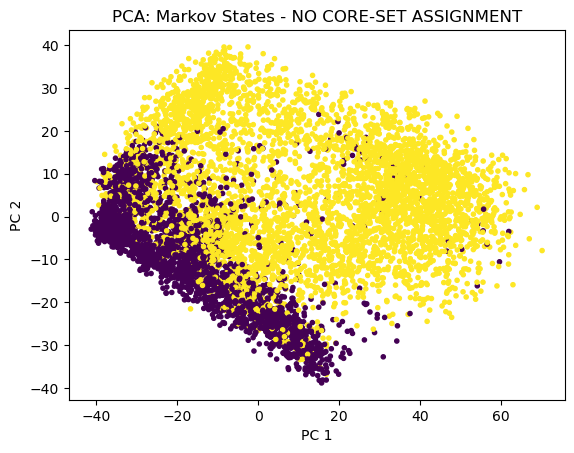

In [27]:
pca_vis = PCA(n_components=2)
data_2d_pca = pca_vis.fit_transform(data)
#data_2d_pca = pca_vis.fit_transform(core_set)

plt.scatter(data_2d_pca[:, 0], data_2d_pca[:, 1], marker=".", c=data_ms_assignation)
plt.title("PCA: Markov States - NO CORE-SET ASSIGNMENT")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

## Let's plot the first eigenvector which corresponds to $\tau_1$

## We observe that there are many fluctuations around 0, which are attributed to numerical error and it is hard to interpret them as being definitively on one side of the eigenvector. So, it is better to consider just the large eigenvalues (maybe 5-10 largest for one particular sign convention) since we can be sure that they relax to equilibrium the same way.

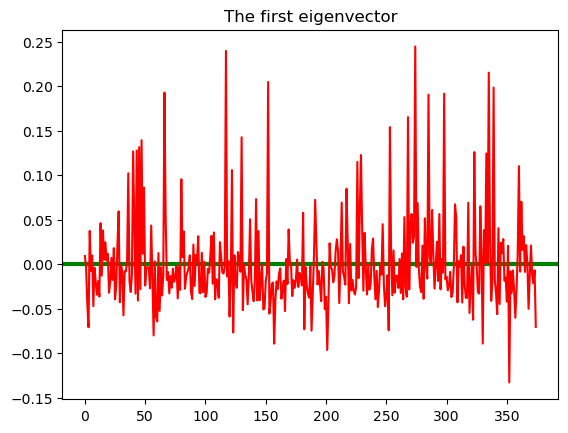

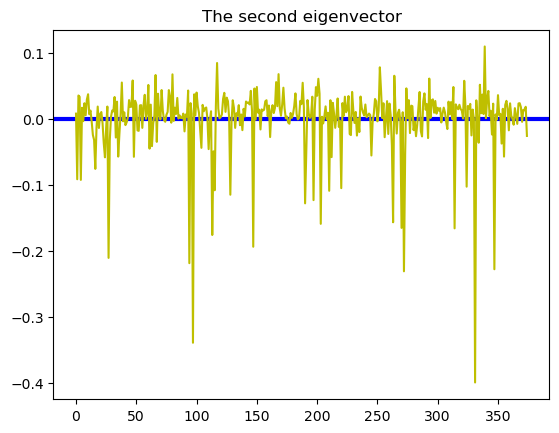

In [28]:
plt.title("The first eigenvector")
plt.axhline(0.0, c="green", lw=3, alpha=1)
plt.plot(eigvecs[:, 1], "r-")
plt.show()

plt.title("The second eigenvector")
plt.axhline(0.0, c="blue", lw=3, alpha=1)
plt.plot(eigvecs[:, 2], "y-")
plt.show()

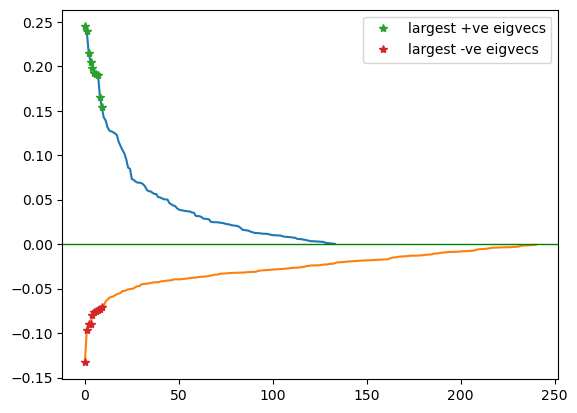

[0.24473579 0.239763   0.21532483 0.20487145 0.19853015 0.19292527
 0.19169508 0.19058246 0.16526696 0.15412505]
[-0.13306575 -0.09658368 -0.08942352 -0.08934207 -0.08014221 -0.07683021
 -0.07482676 -0.07439197 -0.07325914 -0.07096551]
[274 117 335 152 339  66 298 285 268 253]
[352 201 157 330  57 123 188 252 182   3]
0.0003024617932411192
-0.0007808109298227583


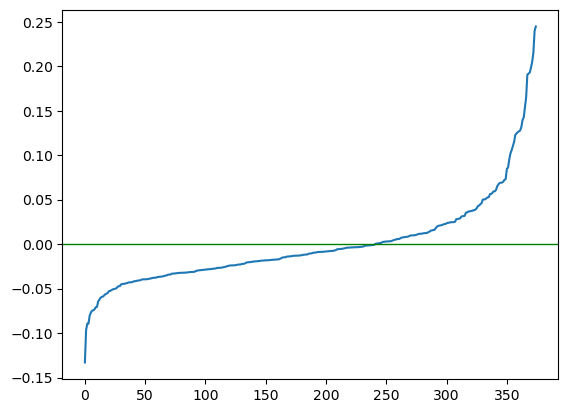

In [29]:
evec_1 = np.real(eigvecs[:, 1])

n_desired_largest_eigvecs = 10

idx_pos = np.argsort(evec_1[(np.where(evec_1 > 0)[0])])[::-1]
idx_neg = np.argsort(evec_1[(np.where(evec_1 < 0)[0])])

plt.plot(evec_1[np.where(evec_1 > 0)[0]][idx_pos])
plt.plot(evec_1[np.where(evec_1 < 0)[0]][idx_neg])

plt.plot(evec_1[np.where(evec_1 > 0)[0]][idx_pos][:n_desired_largest_eigvecs], "*", label="largest +ve eigvecs")
plt.plot(evec_1[np.where(evec_1 < 0)[0]][idx_neg][:n_desired_largest_eigvecs], "*", label="largest -ve eigvecs")
plt.axhline(0.0, c="green", lw=1, alpha=1)
plt.legend()
plt.show()

plt.plot(evec_1[np.argsort(evec_1)])
plt.axhline(0.0, c="green", lw=1, alpha=1)

print(evec_1[np.argsort(-evec_1)][:n_desired_largest_eigvecs])
print(evec_1[np.argsort(evec_1)][:n_desired_largest_eigvecs])

print(np.argsort(-evec_1)[:n_desired_largest_eigvecs])
print(np.argsort(evec_1)[:n_desired_largest_eigvecs])

idx_n_largest_pos_evec_1 = np.argsort(-evec_1)[:n_desired_largest_eigvecs]
idx_n_largest_neg_evec_1 = np.argsort(evec_1)[:n_desired_largest_eigvecs]

print(evec_1[np.where(evec_1 > 0)[0]][idx_pos].min())
print(evec_1[np.where(evec_1 < 0)[0]][idx_neg].max())

#print(evec_1[idx_n_largest_pos_evec_1])
#print(evec_1[idx_n_largest_neg_evec_1])

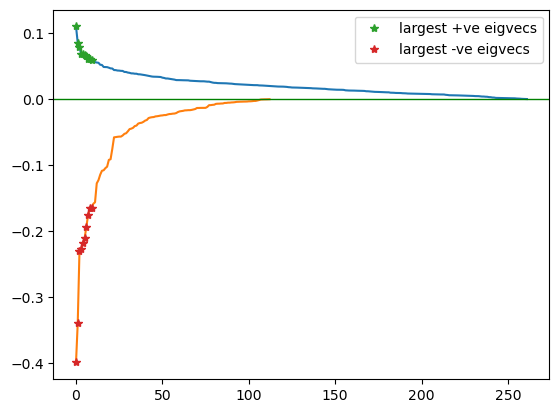

[0.10999283 0.08497392 0.07846885 0.06808791 0.06777945 0.06677854
 0.06564551 0.06137628 0.06108752 0.05848933]
[-0.39870603 -0.33855758 -0.230386   -0.22726928 -0.21806784 -0.21007263
 -0.19318259 -0.17541934 -0.16536171 -0.16464583]
[339 117 252 168  80  66 264 293 201  47]
[331  97 272 347  94  27 147 113 314 270]
0.00011244206740853339
-0.00012001267325646576


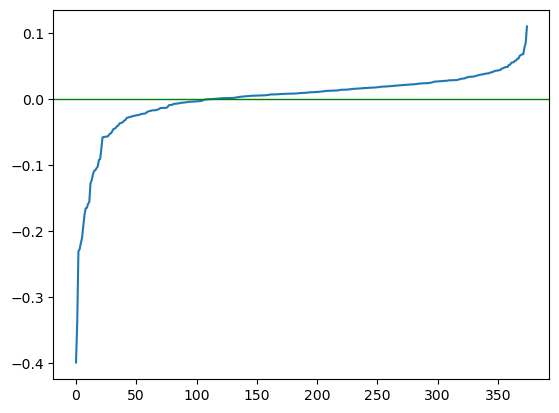

In [30]:
evec_2 = np.real(eigvecs[:, 2])

n_desired_largest_eigvecs = 10

idx_pos = np.argsort(evec_2[(np.where(evec_2 > 0)[0])])[::-1]
idx_neg = np.argsort(evec_2[(np.where(evec_2 < 0)[0])])

plt.plot(evec_2[np.where(evec_2 > 0)[0]][idx_pos])
plt.plot(evec_2[np.where(evec_2 < 0)[0]][idx_neg])

plt.plot(evec_2[np.where(evec_2 > 0)[0]][idx_pos][:n_desired_largest_eigvecs], "*", label="largest +ve eigvecs")
plt.plot(evec_2[np.where(evec_2 < 0)[0]][idx_neg][:n_desired_largest_eigvecs], "*", label="largest -ve eigvecs")
plt.axhline(0.0, c="green", lw=1, alpha=1)
plt.legend()
plt.show()

plt.plot(evec_2[np.argsort(evec_2)])
plt.axhline(0.0, c="green", lw=1, alpha=1)

print(evec_2[np.argsort(-evec_2)][:n_desired_largest_eigvecs])
print(evec_2[np.argsort(evec_2)][:n_desired_largest_eigvecs])

print(np.argsort(-evec_2)[:n_desired_largest_eigvecs])
print(np.argsort(evec_2)[:n_desired_largest_eigvecs])


idx_n_largest_pos_evec_2 = np.argsort(-evec_2)[:n_desired_largest_eigvecs]
idx_n_largest_neg_evec_2 = np.argsort(evec_2)[:n_desired_largest_eigvecs]

print(evec_2[np.where(evec_2 > 0)[0]][idx_pos].min())
print(evec_2[np.where(evec_2 < 0)[0]][idx_neg].max())

#print(evec_2[idx_n_largest_pos_evec_2])
#print(evec_2[idx_n_largest_neg_evec_2])

In [31]:
# Number of relevant relaxation timescales chosen from the eigenvalue spectrum of the transition matrix
num_timescales = 1
num_ms = 2**num_timescales  # number of markov states is 2^(number of relevant timescales)

In [32]:
print(idx_n_largest_neg_evec_1)
print(idx_n_largest_neg_evec_2)

[352 201 157 330  57 123 188 252 182   3]
[331  97 272 347  94  27 147 113 314 270]


In [33]:
# Array to denote which centroid belongs to which Markov State
ms = np.zeros(k)

ms[idx_n_largest_pos_evec_1] = -1
ms[idx_n_largest_neg_evec_1] = +1

#for i in range(k):
#        if eigvecs[i, 1] > 0 and eigvecs[i, 2] > 0:
#            ms[i] = -2
#        elif eigvecs[i, 1] > 0 and eigvecs[i, 2] < 0:
#            ms[i] = -1
#        elif eigvecs[i, 1] < 0 and eigvecs[i, 2] > 0:
#            ms[i] = +1
#        elif eigvecs[i, 1] < 0 and eigvecs[i, 2] < 0:
#            ms[i] = +2

In [34]:
data_ms_assignation = np.zeros_like(labels)

for i in range(len(labels)):
    for j in range(len(ms)):
        if labels[i] == j:
            data_ms_assignation[i] = ms[j]

print(np.min(data_ms_assignation), np.max(data_ms_assignation))

-1.0 1.0


In [35]:
# Now we do core-set assignment where each microstate is assigned to the same markov state as it's history
# That is, if state-30 = +1, and state-60 = +1, then state-(31-59) = +1
# Similarly, state-80 = -1, and state-110 = -1, then state-(81-109) = -1
# Also, if state-160 = -1, and state-190 = +1, then state-(161-189) = -1
# that is, when there are transitions, choose either history/future as convention and stick to it
# there are usually very few such events, so it doesn't matter so much

# the microstates before the first relevant core markov state are assigned to it
first_markov_state_idx = np.where(data_ms_assignation != 0)[0][0]
first_markov_state = data_ms_assignation[first_markov_state_idx]
data_ms_assignation[0:first_markov_state_idx] =  first_markov_state

last_state = first_markov_state

for i in range(len(labels)):
    if data_ms_assignation[i] != 0:
        last_state = data_ms_assignation[i]
    
    if data_ms_assignation[i] == 0:
        data_ms_assignation[i] = last_state
        
# verify that all microstates have been assigned to a core-markov-state
assert data_ms_assignation[data_ms_assignation==0].shape[0] == 0

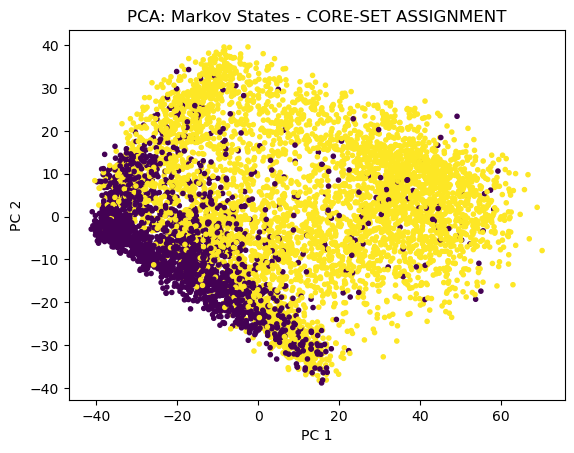

In [36]:
pca_vis = PCA(n_components=2)
data_2d_pca = pca_vis.fit_transform(data)

plt.scatter(
    data_2d_pca[:, 0],
    data_2d_pca[:, 1],
    marker=".",
    c=data_ms_assignation,
)
plt.title("PCA: Markov States - CORE-SET ASSIGNMENT")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

### This isn't the proper core-set assignment methodology in a strictly rigorous manner.

### Reference for proper core-set assignment: https://aip.scitation.org/doi/10.1063/1.3590108

### Also adding some comments from Alessandro about this procedure(remember this was done after the exam):

#### Typically in the core of a genuine markov state the components of the relevant eigenvectors should all be simultaneously high. If this does not happen, probably there is a problem. For example poor convergence, or wrong tau, or not enough separation of time scales. One thing that I did not tell you is that in MD the transition matrix can be simplified taking into account that the dynamics satisfies detailed balance. This, in real applications, is an important step, as it allows finding only real eigenvalues